<a href="https://colab.research.google.com/github/ImitatedSky/module-mnist/blob/main/MNIST_f.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

from pathlib import Path
import requests
import pickle
import gzip

import matplotlib.pyplot as plt
import numpy as np

In [ ]:
#@title loading mnist dataset //這邊沒用到
DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/master/_static/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)
print(PATH / FILENAME)


with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding="latin-1")

data/mnist/mnist.pkl.gz


In [ ]:
#@title args
class Argument():
    def __init__(self,
            batch_size=64, 
            test_batch_size=1000,
            epochs=14, 
            lr=1.0,
            gamma=0.7,
            no_cuda=False, 
            log_interval=100,
            save_model=True
            ):
        
        self.batch_size = batch_size
        self.test_batch_size = test_batch_size
        self.epochs = epochs
        self.lr = lr
        self.gamma = gamma
        self.no_cuda = no_cuda
        self.log_interval = log_interval
        self.save_model = save_model

In [ ]:
#@title Module model
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [ ]:
#@title train
def train(args, model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [ ]:
#@title test
def test(args, model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

In [ ]:
def main():
    args = Argument()
    use_cuda = not args.no_cuda and torch.cuda.is_available()

    device = torch.device("cuda" if use_cuda else "cpu")

    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=args.batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=args.test_batch_size, shuffle=True, **kwargs)

    model = Net().to(device)
    optimizer = optim.Adadelta(model.parameters(), lr=args.lr)  #優化器

    scheduler = StepLR(optimizer, step_size=1, gamma=args.gamma)
    for epoch in range(1, args.epochs + 1):
        train(args, model, device, train_loader, optimizer, epoch)
        test(args, model, device, test_loader)
        scheduler.step()

    if args.save_model:
        torch.save(model.state_dict(), "data/mnist_cnn.pt")
    print(model.state_dict())

In [ ]:
# %%timeit -n 1 -r 2
main()

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw



/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.307327
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.428833
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.384869
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.263620
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.075716
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.113241
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.109398
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.055548
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.303213
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.161346

Test set: Average loss: 0.0550, Accuracy: 9824/10000 (98%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.031793
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.028402
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.032899
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.170683
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.022495
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.008432
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.033543
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.165787
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.020938
T

In [ ]:
# model = Net()
# print(model)
# print('------method 1 模型參數------')
# # for par in model.parameters():
# #   print(par)
# print(model.parameters())
# print('------------')


In [ ]:
# print('------method 2 模型參數------')
# print(model.state_dict())

# print('------模型參數Size------')
# for param_tensor in model.state_dict():
#     print(param_tensor, "\t", model.state_dict()[param_tensor].size())

In [ ]:
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# for var_name in optimizer.state_dict():
#     print(var_name, "\t", optimizer.state_dict()[var_name])

In [ ]:
num_workers = 0
# how many samples per batch to load
batch_size = 100

# convert data to torch.FloatTensor
transform = transforms.ToTensor()

# choose the training and test datasets
trainset = datasets.MNIST(root='MNIST data', train=True,
                                   download=True, transform=transform)
testset = datasets.MNIST(root='MNIST data', train=False,
                                  download=True, transform=transform)

# prepare data loaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
    num_workers=num_workers)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, 
    num_workers=num_workers)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting MNIST data/MNIST/raw/train-images-idx3-ubyte.gz to MNIST data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting MNIST data/MNIST/raw/train-labels-idx1-ubyte.gz to MNIST data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting MNIST data/MNIST/raw/t10k-images-idx3-ubyte.gz to MNIST data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting MNIST data/MNIST/raw/t10k-labels-idx1-ubyte.gz to MNIST data/MNIST/raw



torch.Size([100, 1, 28, 28])
outputs0: tensor([-2.5464, -2.4533, -2.5103, -1.9170, -3.3193, -2.8762, -3.2518, -1.0808,
        -2.7423, -2.6263], grad_fn=<SelectBackward0>)
outputs4: tensor([-2.9549, -2.0168, -3.2069, -2.2920, -1.3201, -2.6067, -3.3365, -2.8163,
        -3.0855, -1.6538], grad_fn=<SelectBackward0>)
pred: tensor([7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5,
        4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 1, 3, 5, 1, 2,
        4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 3, 8, 9, 3, 7, 4, 6, 4, 3, 6, 3, 0,
        2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 9, 3, 1, 1,
        1, 7, 6, 9])


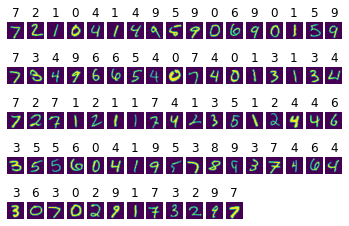

In [ ]:

images,label = next(iter(testloader))
print(images.size())

model = Net()
model.eval()
model.load_state_dict(torch.load("data/mnist_cnn.pt"))

outputs = model(images)
print('outputs0:',outputs[0])
print('outputs4:',outputs[4])
_,pred = torch.max(outputs,1)
print("pred:",pred.data)
n = 80
for i in range(n):
  plt.subplot(5,n/5+1,i+1) # 指定子圖繪製位置
  plt.title(pred[i].numpy()) # 顯示影像標題
  plt.imshow(images[i].reshape(28,28))
  plt.axis("off") # 設定關閉XY軸刻尺
plt.show()

In [ ]:
from google.colab import drive
from IPython.display import Image
from torchvision.datasets import MNIST
import os



images,label = next(iter(testloader))
print(images.size())

model = Net()
model.eval()
model.load_state_dict(torch.load("drive/MyDrive/module/mnist_cnn.pt"))

outputs = model(images)
print('outputs0:',outputs[0])
print('outputs4:',outputs[4])
_,pred = torch.max(outputs,1)
print("pred:",pred.data)
n = 20
for i in range(n):
  plt.subplot(5,n/5+1,i+1) # 指定子圖繪製位置
  plt.title(pred[i].numpy()) # 顯示影像標題
  plt.imshow(images[i].reshape(28,28))
  plt.axis("off") # 設定關閉XY軸刻尺
plt.show()

torch.Size([100, 1, 28, 28])


FileNotFoundError: ignored